# Introduction

The following notebook provides an introduction to the CommonPower framwork, its main components, and design philosophy. 

The primary features of CommonPower are 

- an object-oriented approach to modelling power system entities (object layer),

- a Pyomo-based symbolic math representation of entities to obtain all relevant system equations in the background (pyomo layer),

- interfaces for single/multi-agent reinforcement learning and optimal control,

- a flexible interface to make use of diverse data sources and forecasting models.

The most important object classes for modelling a power system in CommonPower:

- System: This class is the unique "root" of the power system representation. It keeps a list of all nodes and lines in the system.  

- Node: Superclass for busses and components. Can have have subordinate child nodes. Can pull the time series of its characterists from a data source and/or can be controlled.

- Bus: Busses come with an internal power balance equation and sum the cost of their children. 

- Component: Represents a specific electical device, e.g. battery, PV, gas generator, etc. Cannot have children. 
    Implementing subclasses of components allows for flexible modelling of arbitrary devices.

- Line: Represents power transmission lines. Subclasses allow for flexible modelling in conjunction with corresponding power flow models.

- Power Flow: This defines how the power flow is modelled on the system level.

In [1]:
import pathlib
from datetime import timedelta
from commonpower.modelling import ModelHistory
from commonpower.core import System
from commonpower.models.components import *
from commonpower.models.busses import *
from commonpower.models.powerflow import *
from commonpower.data_forecasting import *
from commonpower.utils.param_initialization import *
from commonpower.control.runners import DeploymentRunner
from commonpower.control.controllers import OptimalController

## System set-up

We will create a simple test system constisting of one household with a load, battery, PV system.
We assume the currently realistic scenario that the household pays a constant price for energy imports and gets payed a much smaller per unit amount for energy export. 
The optimization task in such a context would be dispatching the battery to satisfy the household's power demand in the most cost effective way. 
We will use a "global" optimal controller which could in reality for example be run by an energy community manager.

The load/PV components require data providers to read the current power demand/generation and obtain a forecast for it.
To this end, we have included some data from the [SimBench](https://simbench.de/de/datensaetze/) in the tutorial folder.
We rename the variable names of the data to match the requirements of the load/PV component.

In [2]:
# path to data profiles
current_path = pathlib.Path().absolute()
data_path = current_path / 'data'
data_path = data_path.resolve()

load_data = CSVDataSource(data_path / '1-LV-rural2--1-sw' / 'LoadProfile.csv',
            delimiter=";", 
            datetime_format="%d.%m.%Y %H:%M", 
            rename_dict={"time": "t", "H0-A_pload": "p", "H0-A_qload": "q"},
            auto_drop=True, 
            resample=timedelta(minutes=60)
).apply_to_column("p", lambda x: 10*x).apply_to_column("q", lambda x: 0.0)

pv_data = CSVDataSource(data_path / '1-LV-rural2--1-sw' / 'RESProfile.csv', 
        delimiter=";", 
        datetime_format="%d.%m.%Y %H:%M", 
        rename_dict={"time": "t", "PV3": "p"},
        auto_drop=True, 
        resample=timedelta(minutes=60)
).apply_to_column("p", lambda x: -10*x)

price_data = ConstantDataSource({
    "psis": 0.08,  # the household gets payed 0.08 for each kWh transferred to the external grid
    "psib": 0.34  # the houshold pays 0.34 for each imported kWh
    }, date_range=load_data.get_date_range()
)

A data provider is always defined by a datasource and a forecaster providing observations over the control horizon.

In [3]:
control_horizon = timedelta(hours=24)

In [4]:
load_data_provider = DataProvider(load_data, PerfectKnowledgeForecaster(frequency=timedelta(minutes=60), horizon=control_horizon))
pv_data_provider = DataProvider(pv_data, PerfectKnowledgeForecaster(frequency=timedelta(minutes=60), horizon=control_horizon))
price_data_provider = DataProvider(price_data, PerfectKnowledgeForecaster(frequency=timedelta(minutes=60), horizon=control_horizon))

CommonPower's modelling layers (object and pyomo) are built-up as tree stuctures.
On the object layer the root node is always a singleton instance of the `System` class. 
The system then contains an arbitrary number of "top-level" nodes (busses) and lines connecting them. Since power flow calculations are only considered on this top-level, we call this the "power flow level".
Each node can then have subordinate busses or components connected to it.
Nodes' active/reactive power is calculated as the sum of their associated subordinate nodes'/components' power. 
Voltage angle and magnitude are only relevant on the power flow level and enforced for all children of top-level nodes.

We will model our use case as a single bus system consisting of one household and a connection to the external grid. We do, therefore, not need to define any lines. 

When instanciating model entities (e.g. nodes, components) you have to pass them a configuration dict which specifies ranges/values for their model elements (variables/parameters).
You can find out which configurations are needed by calling the info() method or simply trying an empty dict (commonpower will then let you know if it misses something).


In [5]:
ESS.info()


---- INFO: ESS ----

+----------+----------+------------------------------------------+------------------+------------+------------------------------+---------------+
| Element  |   Type   |               Description                |      Domain      |   Bounds   |       Required config        | Data provider |
+----------+----------+------------------------------------------+------------------+------------+------------------------------+---------------+
|    p     |  INPUT   |               active power               |      Reals       |    None    |           [lb, ub]           |               |
|    q     |   VAR    |              reactive power              |      Reals       |    None    |           [lb, ub]           |               |
|   soc    |  STATE   |        state of charge (absolute)        | NonNegativeReals |    None    |           [lb, ub]           |               |
|   rho    | CONSTANT |             cost of wear pu              | NonNegativeReals |    None    | con

In [6]:
household = RTPricedBus("Household").add_data_provider(price_data_provider)
    
# components
# energy storage sytem
capacity = 10  #kWh
ess = ESS("ESS", {
    'rho': 0.001,  # charging/discharging 1 kWh incurs a cost of wear of 0.001
    'p': [-2, 2],  # active power limits
    'q': [0, 0],  # reactive power limits
    'etac': 0.98,  # charging efficiency
    'etad': 0.98,  # discharging efficiency
    'etas': 0.99,  # self-discharge (after one time step 99% of the soc is left)
    'soc': [0.1 * capacity, 0.9 * capacity],  # soc limits
    "soc_init": ConstantInitializer(0.2 * capacity)  # initial soc at the start of simulation
})

# load with data source
load = Load("Load").add_data_provider(load_data_provider)

# pv generator
pv = RenewableGen("PV").add_data_provider(pv_data_provider)

# external grid connection
ext_grid = ExternalGrid("ExternalGrid")

# we first have to add the nodes to the system 
# and then add components to the nodes in order to obtain a tree-like structure
sys = System(power_flow_model=PowerBalanceModel()).add_node(household).add_node(ext_grid)

# add components to household
household.add_node(load).add_node(ess).add_node(pv)

# show system structure: 
sys.pprint()


SYSTEM OVERVIEW 
 
Nodes: 
   n0 (RTPricedBus): Household  
      n0.d00 (Load): Load  
      n0.e01 (ESS): ESS  
      n0.r02 (RenewableGen): PV  
   n1 (ExternalGrid): ExternalGrid  

Lines: 



## Running one day

The most straight-forward control scenario is a single OptimalController which controls all controllable variables in the system.
We run it for one single day.

In [ ]:
sys_history = ModelHistory([sys])
runner = DeploymentRunner(sys=sys, fixed_day = "27.07.2016", history=sys_history)
runner.run()

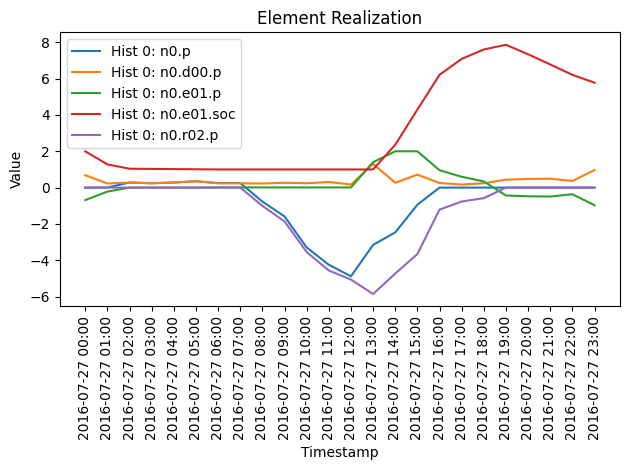

In [8]:
# plot what the household components are doing
sys_history.filter_for_entities(household, True).filter_for_element_names(["p", "soc"]).plot()

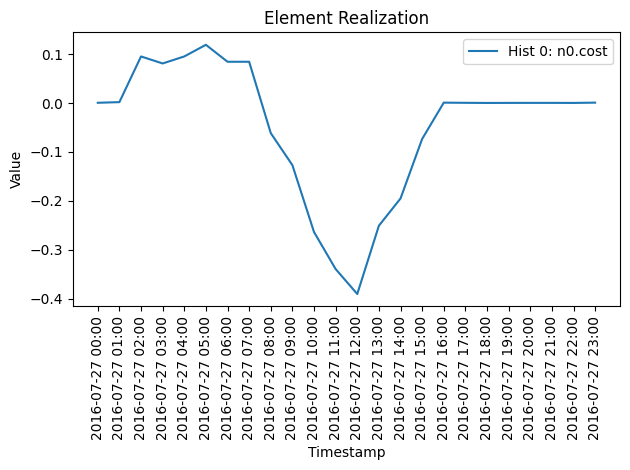

In [9]:
# plot the household cost
sys_history.filter_for_entities(household).filter_for_element_names(["cost"]).plot()

We can see quity nicely how the controller first exports the PV generation and then uses it to charge up the battery for future use.
As a first small study, you could investigate how this behavior adapts if you change the ESS parameters.